#### Инициализация Keras

Для ускорения обучения на GPU следует настраивать backend под конкретную ОС и модель GPU.

Для ускорения pytorch на Windows и свежей карте от NVidia следует установить вместо обычного pytorch:
```
torch = { version = "^2.7.0+cu128", source = "pytorch-cuda128" }
torchaudio = { version = "^2.7.0+cu128", source = "pytorch-cuda128" }
torchvision = { version = "^0.22.0+cu128", source = "pytorch-cuda128" }
```

Обязательно следует включить репозиторий
```
[[tool.poetry.source]]
name = "pytorch-cuda128"
url = "https://download.pytorch.org/whl/cu128"
priority = "explicit"
```

Для macOS можно использовать jax 0.5.0 (обязательно такая версия) + jax-metal 0.1.1

In [1]:
import os

os.environ["KERAS_BACKEND"] = "torch"
import keras

print(keras.__version__)

3.9.2


#### Загрузка набора данных для задачи классификации

В данном примере используется фрагмент набора  данных Cats and Dogs Classification Dataset

В наборе данных два класса (всего 24 998 изображений): кошки (12 499 изображения) и собаки (12 499 изображения)

Ссылка: https://www.kaggle.com/datasets/bhavikjikadara/dog-and-cat-classification-dataset

In [2]:
import kagglehub
import os

path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")
path = os.path.join(path, "PetImages")

#### Формирование выборок

Для формирования выборок используется устаревший (deprecated) класс ImageDataGenerator

Вместо него рекомендуется использовать image_dataset_from_directory (https://keras.io/api/data_loading/image/)

Для использования image_dataset_from_directory требуется tensorflow

ImageDataGenerator формирует две выборки: обучающую и валидационную (80 на 20).

В каждой выборке изображения масштабируются до размера 224 на 224 пиксела с RGB пространством.

Изображения подгружаются с диска в процессе обучения и валидации модели.

In [3]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator

batch_size = 64

data_loader = ImageDataGenerator(validation_split=0.2)

train = data_loader.flow_from_directory(
    directory=path,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="binary",
    batch_size=batch_size,
    shuffle=True,
    seed=9,
    subset="training",
)

valid = data_loader.flow_from_directory(
    directory=path,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="binary",
    batch_size=batch_size,
    shuffle=True,
    seed=9,
    subset="validation",
)

train.class_indices

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


{'Cat': 0, 'Dog': 1}

### Архитектура AlexNet

Модель AlexNet описана в лекции про глубокое обучение

#### Проектирование архитектуры AlexNet

In [4]:
from keras.api.models import Sequential
from keras.api.layers import InputLayer, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

alexnet_model = Sequential()

# Входной слой
alexnet_model.add(InputLayer(shape=(224, 224, 3)))

# Первый скрытый слой
alexnet_model.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation="relu"))
alexnet_model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
alexnet_model.add(BatchNormalization())

# Второй скрытый слой
alexnet_model.add(Conv2D(256, kernel_size=(5, 5), activation="relu"))
alexnet_model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
alexnet_model.add(BatchNormalization())

# Третий скрытый слой
alexnet_model.add(Conv2D(256, kernel_size=(3, 3), activation="relu"))

# Четвертый скрытый слой
alexnet_model.add(Conv2D(384, kernel_size=(3, 3), activation="relu"))

# Пятый скрытый слой
alexnet_model.add(Conv2D(384, kernel_size=(3, 3), activation="relu"))
alexnet_model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
alexnet_model.add(BatchNormalization())

# Шестой скрытый слой
alexnet_model.add(Flatten())
alexnet_model.add(Dense(4096, activation="tanh"))
alexnet_model.add(Dropout(0.5))

# Седьмой скрытый слой
alexnet_model.add(Dense(4096, activation="tanh"))
alexnet_model.add(Dropout(0.5))

# Выходной слой
alexnet_model.add(Dense(1, activation="sigmoid"))

alexnet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 1, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     1,576,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,817,601 (83.23 MB)

 Trainable params: 21,816,129 (83.22 MB)

 Non-trainable params: 1,472 (5.75 KB)

#### Обучение глубокой модели

In [5]:
alexnet_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)

alexnet_model.fit(
    x=train,
    validation_data=valid,
    epochs=100
)

d:\Projects\Python\mai\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
d:\Projects\Python\mai\.venv\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 93s 295ms/step - accuracy: 0.5094 - loss: 1.5595 - val_accuracy: 0.5290 - val_loss: 0.7144
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 92s 294ms/step - accuracy: 0.5305 - loss: 0.7776 - val_accuracy: 0.5314 - val_loss: 0.7015
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 92s 294ms/step - accuracy: 0.5392 - loss: 0.7418 - val_accuracy: 0.5136 - val_loss: 0.7653
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 288ms/step - accuracy: 0.5461 - loss: 0.7339 - val_accuracy: 0.5676 - val_loss: 0.6940
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 97s 310ms/step - accuracy: 0.5631 - loss: 0.7349 - val_accuracy: 0.4854 - val_loss: 0.7876
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 97s 309ms/step - accuracy: 0.5519 - loss: 0.7588 - val_accuracy: 0.5784 - val_loss: 0.7633
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 92s 293ms/step - accuracy: 0.5918 - loss: 0.6969 - val_accuracy: 0.5990 - val_loss: 0.6865
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 87s 277ms/step - accuracy: 0.6017 -

#### Оценка качества модели

Качество модели - 88.2 %.#### Оценка качества модели

In [6]:
alexnet_model.evaluate(valid)

79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.8849 - loss: 0.6870


[0.697141706943512, 0.8823529481887817]

#### Пример использования обученной модели

Для примера используются случайные изображения из сети Интернет

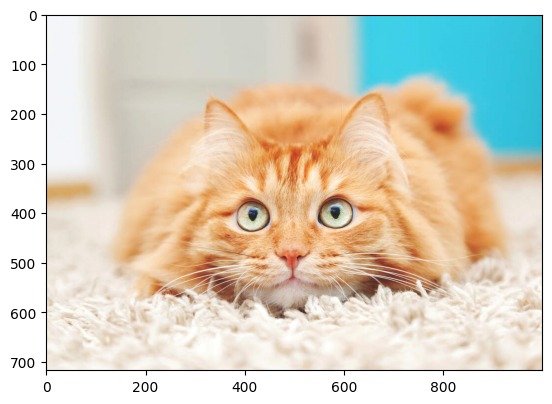

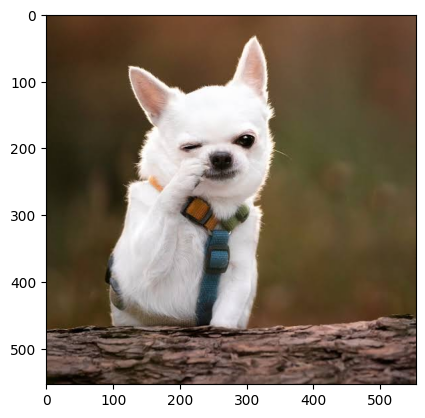

In [16]:
import mahotas as mh
from matplotlib import pyplot as plt

cat = mh.imread("data/-cat.jpg")
plt.imshow(cat)
plt.show()

dog = mh.imread("data/-dog.jpg")
plt.imshow(dog)
plt.show()

In [17]:
resized_cat = mh.resize.resize_rgb_to(cat, (224, 224))

resized_dog = mh.resize.resize_rgb_to(dog, (224, 224))
resized_dog.shape

(224, 224, 3)

In [19]:
results = [
        1
        if alexnet_model.predict(item.reshape(1, 224, 224, 3).astype("float32"))
        > 0.5
        else 0
        for item in [resized_cat, resized_dog]
]

for result in results:
    display(result, list(valid.class_indices.keys())[list(valid.class_indices.values()).index(result)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


0

'Cat'

1

'Dog'